## Classification of Well Productivity with Linear Discriminant Analysis

#### Alan Strayer
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)

### Linear Discriminant Analysis<sup>1</sup>
The goal of linear discriminant analysis (LDA) is to maximize the seperatibility between classes while mininimizing the within-class variance. This is achieved by projecting the feature space into a lower dimension and rotating the principle axes such that the aforementioned criteria of between class seperatibility and minimized within class variance are achieved. This should sound similar to PCA, and it is! However, unlike PCA, LDA considers the classification of the data. This makes LDA a supervised machine learning algorithm. Most importantly, this allows LDA to be trained as a classification algorithm.

##### LDA Assumptions<sup>2</sup>
- Multivariate normality
- Homoscedasticity
- Multicollinearity can reduce predictive power

#### Executive Summary
In this workflow, we explore Linear Discriminant analysis to understand its capabilities as a supervised learning algorithm. In particular, we are interested
in LDA's ability to identify low production wells, moderate production wells, and high production wells given highly dimensional data with many predictor features.
To achieve this, we will... apply minimal pre-processing to test the robustness of the model to violations of it's core assumptions
- Apply minimal pre-processing to test the robustness of the model to violations of it's core assumptions
- Observe the sensitivity of the model to changes in the between class variances
- Split the model into training and testing sets
- Train the model
- Test the model with repeated, stratified, kfold cross-validation
Doing this, we find that the model is robust in the presence of violations to its core assumptions with a minimum observed performance of 88% accuracy among 1000 classification tests. When the spread among groups is increased the performance dramatically increases to 100% performance. These results suggest that this could make an effective model for classification of new wells given petrophysical properties from other subsurface inferential models.

###### *references:*
###### *1* <a href="https://www.youtube.com/watch?v=azXCzI57Yfc">StatQuest with Josh Starmer</a> ...Mind the intro
###### *2* <a href="https://en.wikipedia.org/wiki/Linear_discriminant_analysis">Linear Discriminant Analysis-Wikipedia</a>

In [463]:
import copy  # needed to prevent overwrite of data

import pandas as pd  # data manipulation performed, primarily, with pandas under-the-hood speedups
import numpy as np  # various calculations using numpy functionality
import scipy.stats as st  # Calculate confidence interval
import seaborn as sns  # seaborn plots for pairpliot and

from prettytable import PrettyTable  # Because data looks better pretty (tabular)
from ipywidgets import fixed  # required to feed non-slider values into function that utilizes slider capability
import ipywidgets as widgets  # needed for

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split  # split the data into training and testing subsets
from sklearn.model_selection import RepeatedStratifiedKFold  # cross-validation method
from sklearn.model_selection import cross_val_score  # assessing that accuracy of the model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # the model of interest

In [546]:
# Define functions

def class_scaling_factor(dset, min_val=1, max_val=5, step_sz=0.01, slider_width='500px'):
    """
    Method to instantiate Ipywidget float slider objects
    for feature range adjustment
    
    :param dset: dataframe containg all features
    :param min_val: minimum slider value. Default value is 0.01
    :param max_val: maximum slider value. Default value is 5
    :param slider_width: width of the slider bar in pixels. Default width is 500px
    :return ret_obj: returns the instantiated float slider object
    """
    ret_obj = widgets.FloatSlider(
        value=1,
        min=min_val,
        max=max_val,
        step=step_sz,
        description="Class Scaling Factor",
        layout=widgets.Layout(width='500px')
    )
    return ret_obj

def data_updater(sf, orig_data, features):
    """
    Adjusts feature sets based on class. multiplies the high_production class by a scaling factor
    and divides the low production class by the same scaling factor
    
    :param sf: Scaling Factor
    :param orig_data: The original dataframe
    :param features: list of features to apply the scaling factors to
    :return new_data: new feature data
    """
    # Ensure class is not included in the manipulation
    features = copy.deepcopy([x for x in features if x != 'class'])
    new_data = copy.deepcopy(orig_data)
    # Update the high production class
    new_data.loc[new_data['class']=='high_production', features] = copy.deepcopy(
        new_data.loc[new_data['class'] == 'high_production', features]
    ) * sf
    # Truncate porosity > 100
    new_data.loc[new_data.Por > 100, 'Por'] = 100
    
    # Update the low production class
    new_data.loc[new_data['class']=='low_production', features] = copy.deepcopy(
        new_data.loc[new_data['class'] == 'low_production', features]
    ) * (1/sf)
    
    return new_data

def interactive_pairplot(scalf, feature_set, feat_list):
    """
    Method to allow the user to increase the feature magnitude for high production wells
    and decrease the feature magnitude for low production wells
    
    :param scalf: Scaling factor, can be applied manually or generated with the
    class_scaling_factor method
    :param feature_set: the original dataset with classes defined
    :param feat_list: the list of features for which to generate the pairplot
    :return scaled_data: dataframe of scaled-class data
    """
    global scaled_data
    scaled_data = data_updater(scalf, feature_set, feat_list)

def data_mean_var_display(dset, ft, return_mean_df=True, return_var_df=True, return_tab_obj=True, suppress_print=False):
    """
    Method to return a PrettyTable of the data mean and variance across all features
    as well as the within class variance
    
    :param dset: the dataframe containing the data
    :param ft: list of features for which to generate statistics
    :param return_mean_df: whether or not to return a dataframe of mean values of features
    :param return_var_df: whether or not to return a dataframe of variances of the features
    :param return_tab_obj: whether or not to return the pretty table object
    :param suppress_print: Whether or not to supress the PrettyTable print statement
    """
    mn_df = dset.loc[:, ft].mean(axis=0)  # 
    v_df = dset.loc[:, ft].var(axis=0)
    low_df = dset.loc[dset['class']=='low_production', ft].var(axis=0)
    mod_df = dset.loc[dset['class']=='moderate_production', ft].var(axis=0)
    hi_df = dset.loc[dset['class']=='high_production', ft].var(axis=0)

    mean_var_table = PrettyTable(['Feature', 'Mean', 'Variance',
                                  'Low Production Variance', 'Moderate Production Variance', 'High Production Variance'])

    for feet, mn, vr, ldf, mdf, hdf in zip(mn_df.index, mn_df.values, v_df.values, low_df.values, mod_df.values, hi_df.values):
        mean_var_table.add_row(
            [feet, np.round(mn, 3), np.round(vr, 3), np.round(ldf, 3), np.round(mdf, 3), np.round(hdf, 3)]
        )
    if suppress_print is False:
        print(mean_var_table)
    if return_mean_df is True and return_var_df is False:
        return mn_df
    if return_mean_df is False and return_var_df is True:
        return v_df
    if return_mean_df is True and return_var_df is True:
        return mn_df, v_df
    if return_tab_obj is True:
        return mean_var_table

def train_test_scor(pdata, trn_sz):
    """
    Method to train the LDA model, cross-validate, and score the model on testing data
    production response feature should be removed prior to applying this method
    as the class is the response feature we are interested in
    
    :param pdata: processed data including class categorization for production
    :param trn_sz: percentage of data to split into training data group
    :return: array of accuracy scores
    """
    # get predictor features passed with the dataset (separate from class)
    pfeatures = [x for x in pdata.columns.values if x != 'class']
    
    # split data into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(pdata.loc[:, pfeatures], pdata['class'], train_size=trn_sz, random_state=47)

    # Fit LDA model to training data
    lda = LinearDiscriminantAnalysis()  # Instantiate the LDA model
    lda.fit(X_train, y_train)  # fit the model to the training data

    # Test the model with cross-vaildation via Repeated Stratified K-Fold
    cross_v = RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=47)  # define the cv method

    # Obtain the cross-validation score. Implement the cv method with the testing data
    scores = cross_val_score(lda, X_test, y_test, scoring='accuracy', cv=cross_v, n_jobs=-1)
    
    return scores

### Import the dataset, set the random seed, and define the features of interest from the dataset

In [549]:
# Import the dataset
data = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv')

# Initialize the numpy random seed for consistency
np.random.seed(seed=47)

# Define the initial predictor and response features
feat = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']
subfeat = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']

### Split the data into three production categories (Arbitrary categorization)
- High production: the upper third of the range of production values
- Moderate production: the middle third of the range of production values
- Low production: the lower third of the range of production values

In [466]:
#calculate the production categories (low, moderate, high)
increment = (data.Prod.max() - data.Prod.min())/3  # split the data evenly into 3 production classes. Making a lot of assumptions here...
hi_prod = data.Prod.max() - increment
low_prod = data.Prod.min() + increment

print(f"""
Low production volumes are less than {np.round(low_prod, 2)} units
Moderate production volumes are greater than {np.round(low_prod, 2)} and less than {np.round(hi_prod, 2)} units
High production volumes are greater than {np.round(hi_prod,2)} units

With this information we can add these classes to the dataset for all wells
""")


Low production volumes are less than 3625.63 units
Moderate production volumes are greater than 3625.63 and less than 5144.13 units
High production volumes are greater than 5144.13 units

With this information we can add these classes to the dataset for all wells



In [541]:
# Add classes to the dataset
data.loc[data.Prod < low_prod, 'class'] = 'low_production'
data.loc[(data.Prod >= low_prod) & (data.Prod < hi_prod), 'class'] = 'moderate_production'
data.loc[data.Prod >= hi_prod, 'class'] = 'high_production'

### Adjust the between-production class variance:
- the slider allows the manipulation of the between class variance
- A Scaling Factor of 1 returns the original dataset
- A Scaling Factor $\ge 1$ returns a new dataset where the variance between classes (low, moderate, high) is increased

#### Execution instructions:
1. Execute the cell block
2. Adjust the slider
3. Click the "Run Interact button"
4. Evaluate results in the next cell block

In [536]:
# Adjust production classes and return the adjusted data
pair_widge = widgets.interact_manual(interactive_pairplot, feature_set=fixed(data), feat_list=fixed(subfeat),
                        scalf=class_scaling_factor(data))  # displays the first 5 and last 5 rows of the updated
                                                           # dataframe in addition to the pairplot as a bonus!

interactive(children=(FloatSlider(value=1.0, description='Class Scaling Factor', layout=Layout(width='500px'),…

### Evaluation of the New Dataset
Provided are two tables and a pairplot. Both tables provide the feature mean and variance for the total dataset and the within class
feature variance. The first table provides metrics for the original dataset and the the second provides metrics for the updated dataset
for comparison. The pairplot allows for the visual observation of the relationships between features as the variance between classes is
updated. Note the following general observations:
- As the scaling factor increases, the overal mean and variance of the feature data increase
    - The within class feature variance for low production wells decreases
    - The within class feature variance for moderate production wells stays the same
    - The within class feature variance for high production wells increases

Original Feature Mean and Variance:
+---------+---------+------------+-------------------------+------------------------------+--------------------------+
| Feature |   Mean  |  Variance  | Low Production Variance | Moderate Production Variance | High Production Variance |
+---------+---------+------------+-------------------------+------------------------------+--------------------------+
|   Por   |  14.991 |   8.828    |          4.956          |            3.586             |          1.146           |
|   Perm  |  4.331  |   2.996    |          1.215          |             1.52             |          2.678           |
|    AI   |  2.969  |   0.321    |          0.266          |            0.313             |          0.228           |
| Brittle |  48.162 |  199.641   |         256.286         |           207.081            |          69.857          |
|   TOC   |   0.99  |   0.232    |          0.184          |             0.17             |          0.103           |
|    VR   | 

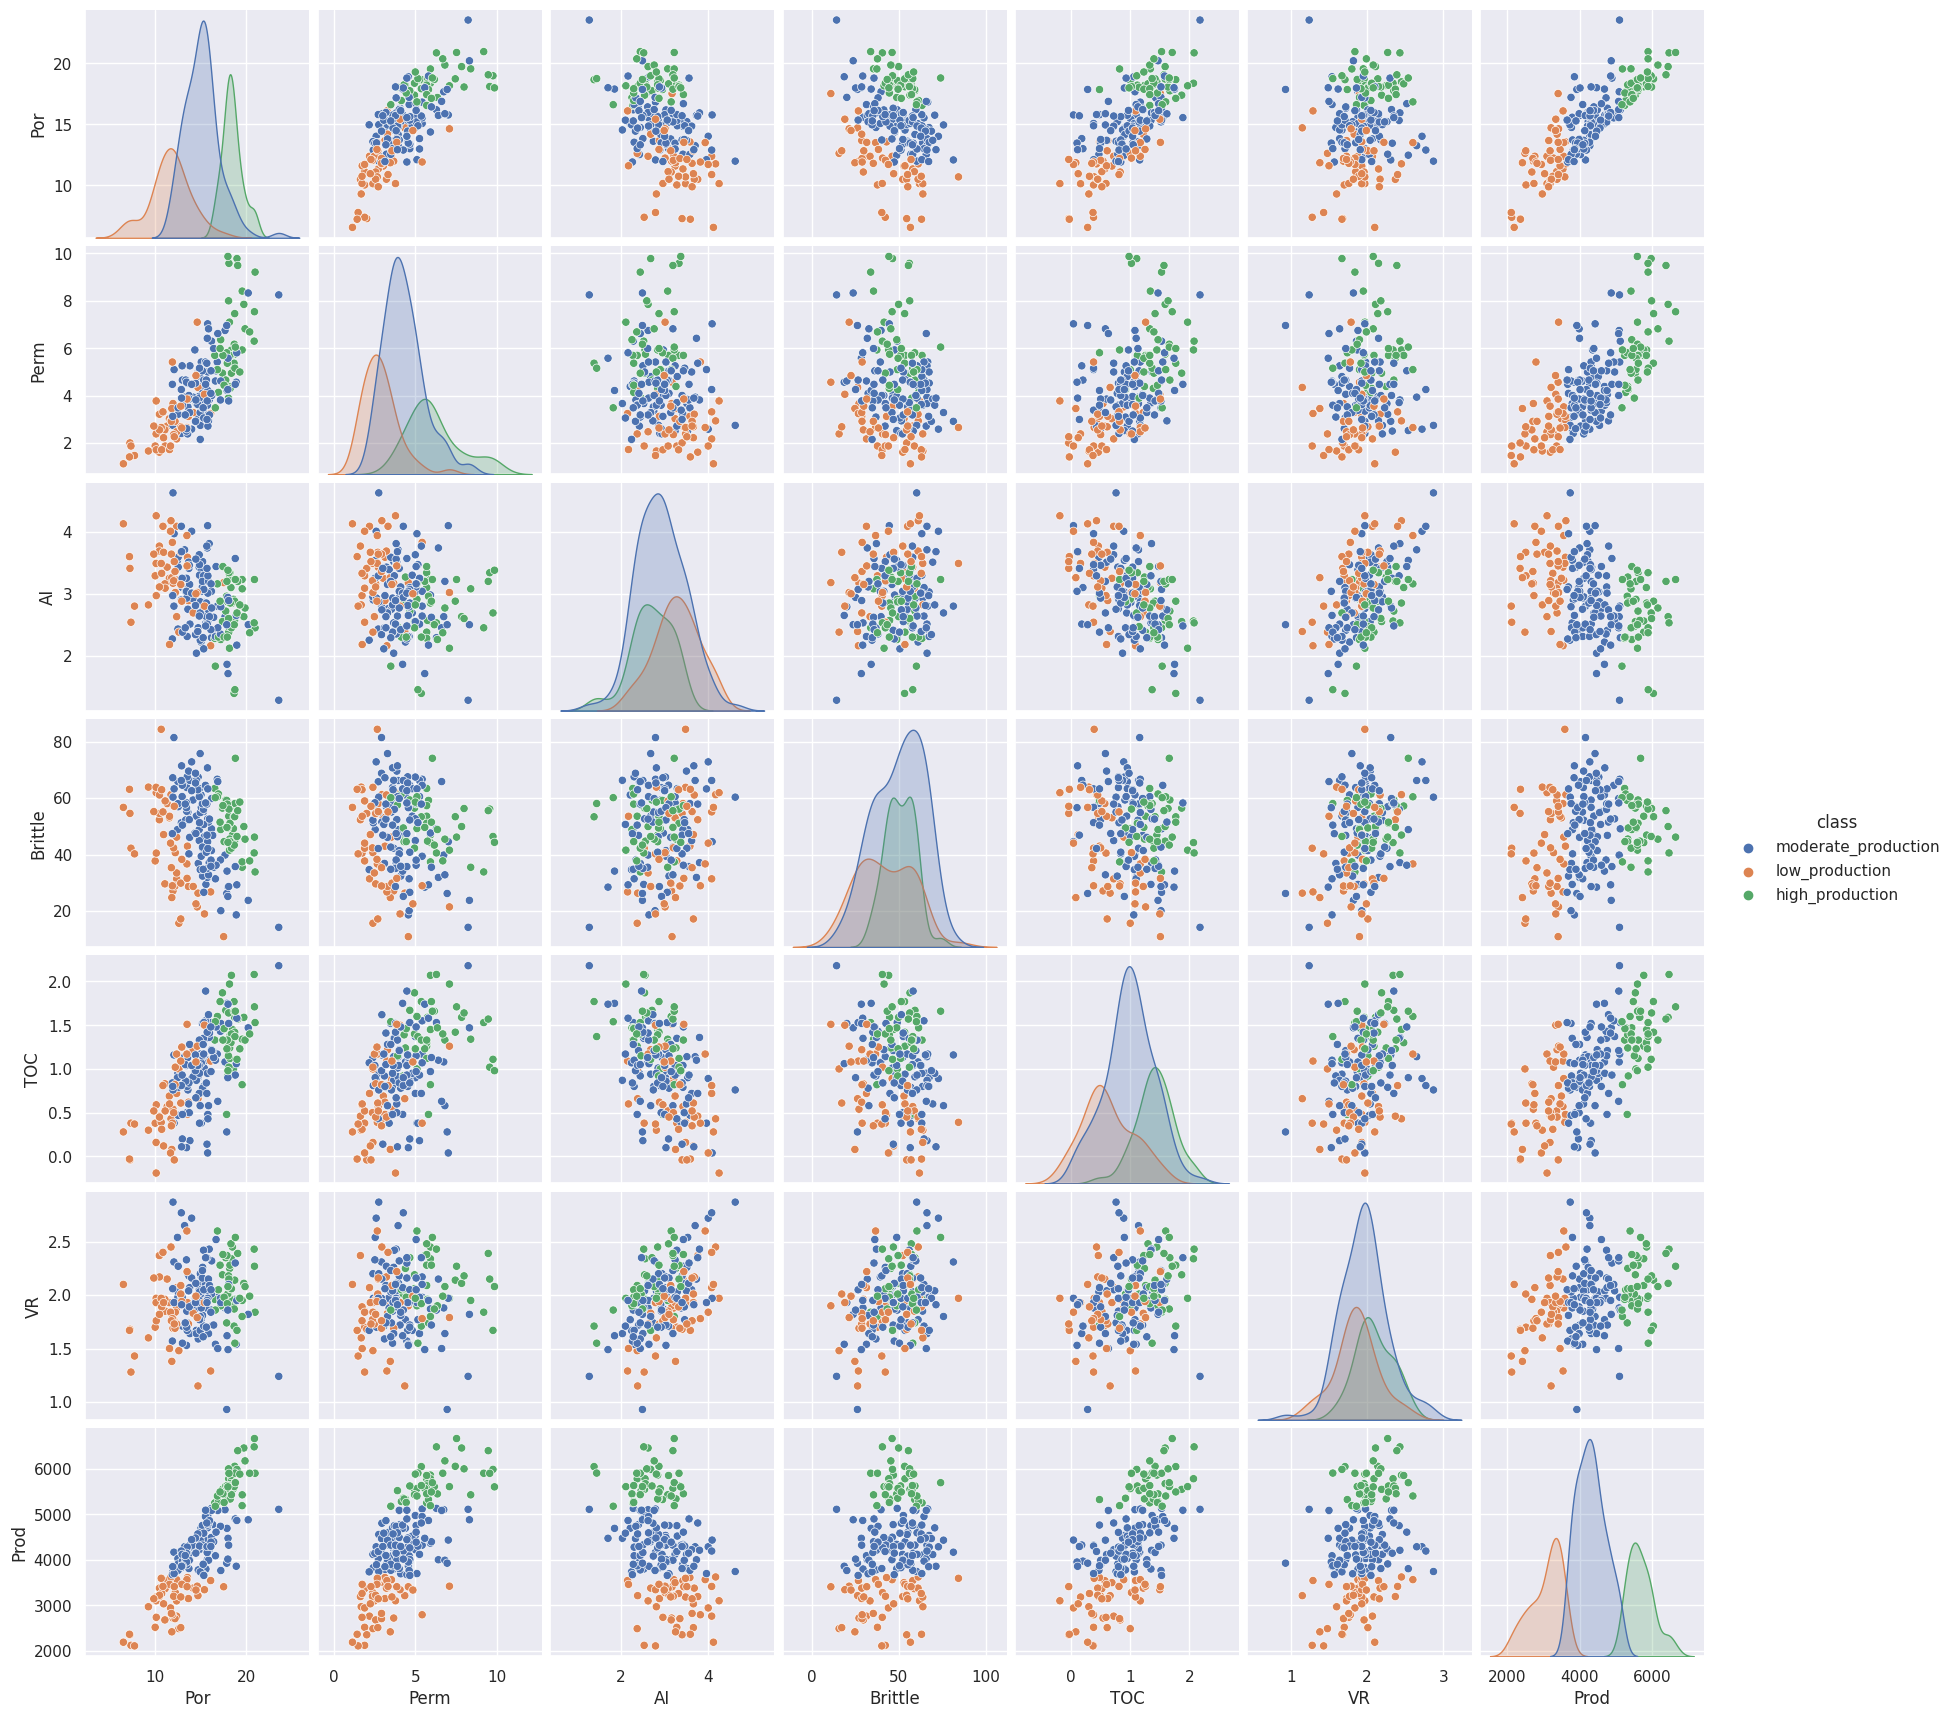

In [544]:
# Evaluate the initial (Default) mean and variance from the unconv_MV_v5 dataset -- Courtesy of Dr. Pyrcz (Thanks!)
print('Original Feature Mean and Variance:')
orig_table = data_mean_var_display(data, feat, return_mean_df=False, return_var_df=False)
print('Updated Feature Mean and Variance:')
udata = copy.deepcopy(scaled_data)  # dataframe of updated data
updated_table = data_mean_var_display(udata, feat, return_mean_df=False, return_var_df=False)

sns.pairplot(udata.loc[:, [*feat,'class']], hue='class')

### Training, Testing, Scoring
Here, the model is split 50/50 into training and testing data groups. The training data are fit to the Linear Discriminant Analysis Model
and the testing data are applied to repeated, stratified, kfolds cross-validation with 10 folds and 100 repeats.

#### Results
The results suggest that LDA performs very well at classifying production wells, even with classification groups that have low variance between the group means. Slight increases in the classification group variance, as observed by adjusting the slider above, reveals that the model rapidly achieves 100% classification accuracy. Note that this happens with minimal preprocessing of the data, no gaussian anamorphosis or standard scaling, and even as non-linearity between features appears as the classification clusters are spread apart.

the 1000 iteration average model accuracy is: 88.0% (95% CI: 87.0%, 88.0%)


Text(0.5, 1.0, 'Model Performance Variation')

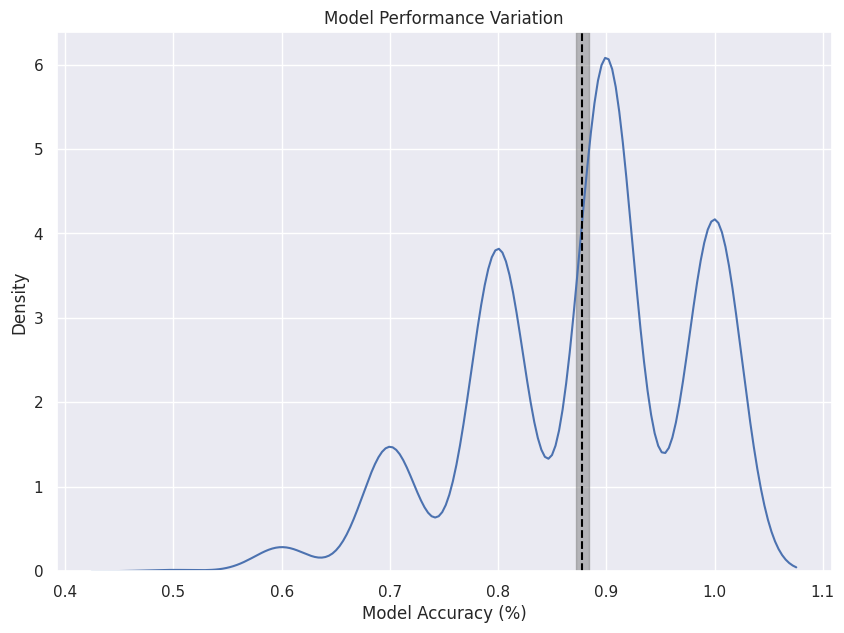

In [547]:
# Remove production from the dataset (class becomes the response feature)
mdata = udata.loc[:, [*subfeat,'class']]

scrs = train_test_scor(mdata, 0.5) # Train the model, Test the model, Score the performance

# Print the average model accuracy to the screen
conf_int = st.t.interval(confidence=0.95, df=len(scrs)-1, loc=np.mean(scrs), scale=st.sem(scrs))  # obtain the 95% confidence interval about the mean
print(
f"the {len(scrs)} iteration average model accuracy is: {np.round(np.mean(scrs), 2)*100}% (95% CI: {np.round(conf_int[0], 2)*100}%, {np.round(conf_int[1], 2)*100}%)"
)

performance_plot = sns.kdeplot(scrs)  # distribution plot across many iterations to evaluate the overall performance of the LDA classification model
performance_plot.axvline(x=np.mean(scrs), linestyle='--', c='black')  # dshed black line for mean model accuracy
performance_plot.axvspan(xmin=conf_int[0], xmax=conf_int[1], color='gray', alpha=0.5)  # Gray shaded confidence interval
performance_plot.set_xlabel('Model Accuracy (%)')
performance_plot.set_title('Model Performance Variation')

### Parting Words:
Though LDA makes an excellent, lightweight classification algorithm, we can observe by adjusting the between-class
variance that LDA struggles with classes with a high-degree of overlap. In these situations it is better to use a
more advanced algorithm such as <a href="https://www.youtube.com/watch?v=UpN6TLMJiGg&list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&index=40">Support Vector Machines</a>. You can learn more about this topic from GeostatsGuy Lectures (Dr. Michael Pyrcz) by following the provided link.

#### Shameless self-promotion:
You can also reach-out to me via my LinkedIn profile <a href="https://www.linkedin.com/in/alan-r-strayer-37102434">here</a>